# Quick Start

## Installation

The package can be installed from PyPI using `pip install pymatgen-analysis-defects`. 

Once installed, the different modules can be imported via the `pymatgen.analysis.defects` namespace.

```python
from pymatgen.analysis.defects import core, ccd, finder
```

To ensure that the namespace is installed properly run

In [1]:
from pymatgen.analysis.defects.core import __file__

and look at the `__file__` variable to make sure that it is accessing the code from `pymatgen-analysis-defect` and not `pymatgen`.

## Definition of a defect

Our code defines defects using a combination of bulk structure and sites.
Since the bulk primitive structure is, in principle, unique up to arbitrary translations, equivalence of defects can be now easily checked using `StructureMatcher`.

Below we show how you can create a basic substitutional defect from a `pymatgen.core.Structure` object by replacing one of the Ga atoms in GaN with Mg.

Note that we create a Mg<sub>Ga</sub> defect by creating a PeriodicSite Object `mg_ga` with the data of the first Ga site but 


In [2]:
from pathlib import Path

from pymatgen.analysis.defects.core import Substitution
from pymatgen.core import PeriodicSite, Species, Structure

TEST_FILES = Path("../../../tests/test_files")

In [3]:
gan_struct = Structure.from_file(TEST_FILES / "GaN.vasp")
# make a substitution site
ga_site = gan_struct[0]
mg_site = PeriodicSite(
    species=Species("Mg"), coords=ga_site.frac_coords, lattice=gan_struct.lattice
)
# instantiate the defect object
mg_ga = Substitution(structure=gan_struct, site=mg_site)
print(mg_ga)

Mg subsitituted on the Ga site at at site #0


In [4]:
mg_ga.defect_structure

Structure Summary
Lattice
    abc : 3.2162901334217344 3.2162901334217344 5.239962
 angles : 90.0 90.0 120.00000274450079
 volume : 46.9428220153705
      A : 1.608145 -2.785389 0.0
      B : 1.608145 2.785389 0.0
      C : 0.0 0.0 5.239962
    pbc : True True True
PeriodicSite: Mg2+ (1.6081, -0.9285, 2.6154) [0.6667, 0.3333, 0.4991]
PeriodicSite: Ga3+ (1.6081, 0.9285, 5.2354) [0.3333, 0.6667, 0.9991]
PeriodicSite: N3- (1.6081, -0.9285, 4.5896) [0.6667, 0.3333, 0.8759]
PeriodicSite: N3- (1.6081, 0.9285, 1.9696) [0.3333, 0.6667, 0.3759]

## Instantiating `FormationEnergyDiagram`

The object responsible for analyzing the formation energy is described by the following fields.

```python
FormationEnergyDiagram(
    bulk_entry: 'ComputedStructureEntry',
    defect_entries: 'List[DefectEntry]',
    pd_entries: 'list[ComputedEntry]',
    vbm: 'float',
    band_gap: 'Optional[float]' = None,
    inc_inf_values: 'bool' = True,
)
```

Using a convenience constructor `with_directories` you can just feed in dictionary of {`str`: `Path`} 
pointing to the directories where the supercell calculations are stored.
The keys, other than `bulk` will be the charge states of the calculations.
As long as the `vasprun.xml` and `LOCPOT` files are in the directories the `FormationEnergyDiagram` object can be constructed.

In [5]:
import warnings

from monty.serialization import loadfn
from pymatgen.analysis.defects.thermo import FormationEnergyDiagram
from pymatgen.io.vasp import Vasprun

warnings.filterwarnings("ignore")

sc_dir = TEST_FILES / "Mg_Ga"
# ents = MPRester().get_entries_in_chemsys("Mg-Ga-N") # Query from MPRester
ents = loadfn(TEST_FILES / "Ga_Mg_N.json")  # Load from local
fed = FormationEnergyDiagram.with_directories(
    directory_map={
        "bulk": sc_dir / "bulk_sc",
        0: sc_dir / "q=0",
        -1: sc_dir / "q=-1",
        1: sc_dir / "q=1",
    },
    defect=mg_ga,
    pd_entries=ents,
    dielectric=10,
)

## Getting the formation energy diagram

The chemical potential limits can be access using:

In [6]:
fed.chempot_limits

[{Element Mg: -0.7462673672916758,
  Element Ga: -0.6568168687500027,
  Element N: 3.552713678800501e-15},
 {Element Mg: -0.30838945479167634,
  Element Ga: 3.552713678800501e-15,
  Element N: -0.6568168687499991}]

If you have `crystal_toolkit` and the its jupyter lab extensions installed you can view the chemical potential diagram by importing `crystal_toolkit` and running a cell with the the `chempot_diagram` on the last line.

```python
import crystal_toolkit
fed.chempot_diagram
```

Note that it is different from chemical potential plot hosted on the material project because the elemental phases are set to zero energy.

<img src="https://github.com/materialsproject/pymatgen-analysis-defects/blob/main/docs/source/_static/img/mg_gan_chempot.png?raw=true" width="600" />



Now we can plot the formation energy diagram by calculating the _Fermi level_ and _formation energy_ at the different charge state transitions. 

Text(0, 0.5, 'Formation Energy(eV)')

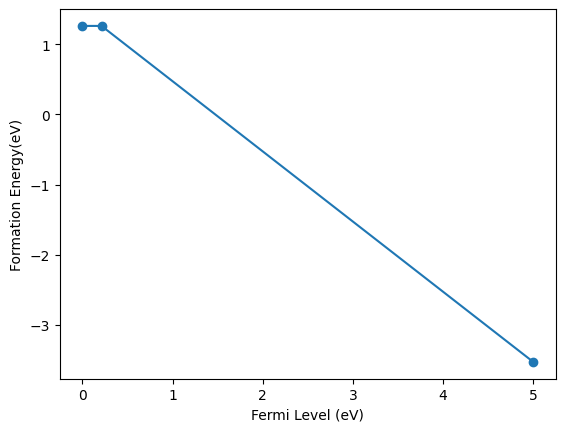

In [7]:
import numpy as np
from matplotlib import pyplot as plt

ts = np.array(fed.get_transitions(fed.chempot_limits[1], x_max=5))
plt.plot(ts[:, 0], ts[:, 1], "-o")
plt.xlabel("Fermi Level (eV)")
plt.ylabel("Formation Energy(eV)")